# pyFEHM Tutorial Part 2: EGS Case study

In [1]:
# Initial setup
from fdata import *
from fpost import *

work_dir = 'tutorial2'
dat = fdata(work_dir=work_dir)

### GRID GENERATION

Because we will model injection and production against fixed pressures,
it is crucial that pressure gradients in the vicinity of the well be
fully-resolved. To this end, it will be useful to have a mesh with
variable resolution: fgrid.make() is useful for generating such meshes.

First, lets define some dimensions for the mesh. We want it to extend 1
km in each of the horizontal dimensions, and span between -500 and -1500 m
depth (assuming z = 0 corresponds to the surface).

In [2]:
X0, X1 = 0, 1.e3
Z0, Z1 = -1.5e3, -0.5e3

We need to know the position of the injection and production wells so the
mesh can be refined in the vicinity. The injection well is in the centre
(the corner of the quarter spot) and the production well is at (300,300)

In [3]:
injX, injY = 0., 0.
proX, proY = 300., 300.

A power-law scaled node spacing will generate closer spacing nearer the
injection and production locations.

In [4]:
base = 3
dx = proX / 2.
x = dx ** (1 - base) * np.linspace(0, dx, 8) ** base
dx2 = X1 - proX
x2 = dx2 ** (1 - base) * np.linspace(0, dx2, 10) ** base
X = np.sort(list(x) + list(2 * dx - x)[:-1] + list(2 * dx + x2)[1:])

Injection and production will be hosted within an aquifer, confined above
and below by a caprock. We need to define the extent of these formations.

In [5]:
Za_base = -1.1e3
Za_top = -800.

As all the action will be going on in the aquifer, we will want
comparatively more nodes in there.

In [6]:
Z = list(np.linspace(Z0, Za_base, 5)) + list(
    np.linspace(Za_base, Za_top, 11))[1:] + list(
    np.linspace(Za_top, Z1, 5))[1:]

Now that the node positions have been defined, we can create the mesh
using the fgrid.make() command.

<Figure size 432x288 with 0 Axes>

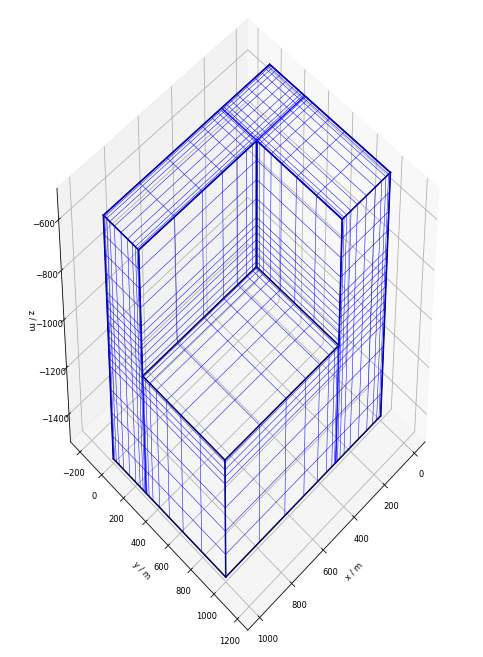

In [7]:
dat.grid.make('quarterGrid.inp', x=X, y=X, z=Z)
dat.grid.plot('quarterGrid.png', angle=[45, 45], color='b',
              cutaway=[proX, proY, -1000.])

### ZONE CREATION
This problem has three defined zones, a reservoir (denoted res) and upper
and lower confining formations (denoted con). For simplicity, we will not
assign different material properties to the two confining layers.

Before we can assign material properties via the PERM, ROCK and COND
macros, we need zones to which these macros can be assigned. As these
zones are rectangular, we will define them using the new_zone() method,
passing it the rect argument for a bounding box defined by two corner
points. First the reservoir zone.

In [8]:
dat.new_zone(10, name='reservoir',
             rect=[[X0 - 0.1, X0 - 0.1, Za_base + 0.1],
                   [X1 + 0.1, X1 + 0.1, Za_top - 0.1]])

We can plot which nodes are contained in the reservoir zone to verify we
have made the correct selection (see Figure 7.1).

<Figure size 432x288 with 0 Axes>

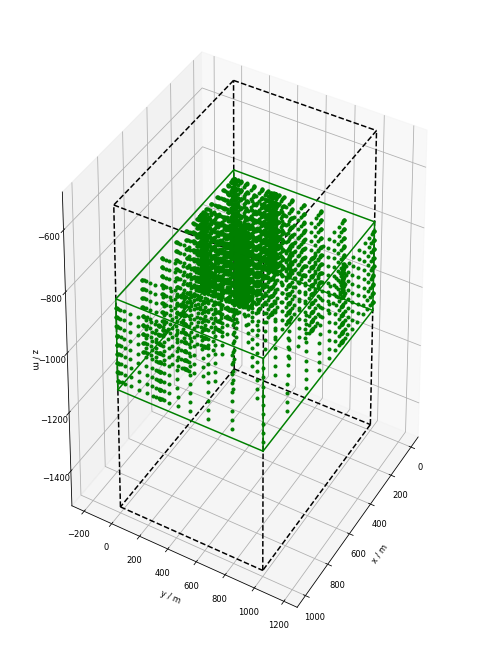

In [9]:
dat.zone['reservoir'].plot('reservoirZone.png', color='g', angle=[30, 30])


The two confining zones are generated similarly

In [10]:
dat.new_zone(20, name='confining_lower',
             rect=[[X0 - 0.1, X0 - 0.1, Z0 - 0.1],
                   [X1 + 0.1, X1 + 0.1, Za_base + 0.1]])
dat.new_zone(21, name='confining_upper',
             rect=[[X0 - 0.1, X0 - 0.1, Za_top - 0.1],
                   [X1 + 0.1, X1 + 0.1, Z1 + 0.1]])

### MATERIAL PROPERTY ASSIGNMENT
First, declare some parameters: permeability (perm), density (rho),
porosity (phi), thermal conductivity (cond), and specific heat (H).

In [11]:
perm_res, perm_con = 1.e-14, 1.e-16
rho_res, rho_con = 2300., 2500.
phi_res, phi_con = 0.1, 0.01
cond = 2.5
H = 1.e3

Now, create a new fmacro object to which to assign reservoir permeability.
For this first time, we will take an unnecessary number of steps to
demonstrate macro assignment

In [12]:
perm = fmacro('perm')
perm.zone = 'reservoir'
perm.param['kx'] = perm_res
perm.param['ky'] = perm_res
perm.param['kz'] = perm_res
dat.add(perm)

In general, this process can be streamlined to a few or even a single
step, e.g., assigning upper confining formation permeability

In [13]:
perm = fmacro('perm', zone=21,
              param=(('kx', perm_con), ('ky', perm_con), ('kz', perm_con)))
dat.add(perm)

Permeability can also be assigned to a zone through its permeability
attribute. Behind the scenes, PyFEHM takes care of the macro definition
and zone association required by FEHM to assign this permeability.

In [14]:
dat.zone['confining_lower'].permeability = perm_con


Similarly, rock properties are defined either through a macro object, or
by zone attributes, e.g., through a macro object...

In [15]:
dat.add(fmacro('rock', zone=dat.zone['reservoir'], param=(
                ('density', rho_res),
                ('specific_heat', H),
                ('porosity', phi_res))))
dat.add(fmacro('rock', zone=dat.zone['confining_lower'], param=(
                ('density', rho_con),
                ('specific_heat', H),
                ('porosity', phi_con))))

...or through zone attributes:

In [16]:
dat.zone['confining_upper'].density=rho_con
dat.zone['confining_upper'].specific_heat=H
dat.zone['confining_upper'].porosity=phi_con

Thermal conductivity (COND) properties are to be the same everywhere, so
we will use the conductivity attribute of zone 0.

In [17]:
dat.zone[0].conductivity = cond

### INJECTORS AND PRODUCERS
The EGS problem requires both injection and production wells. To
demonstrate some of FEHMs flexibility, we will include a source that
injects cold fluid at a fixed rate, and a production well that operates
against a specified production pressure.

First we require a zone for each of the production and injection wells.
For the injection well, we will consider fluid exiting the wellbore over
an open-hole length, i.e., sources at multiple nodes. For the production
well, we will consider a single feed-zone at a fixed depth, i.e., a single
node sink.

First define the open hole injection nodes. The aquifer extends from
-1100 to -800 m depth; we will choose a 100 m open hole section between
-1000 and -900 m. Nodes contained in this zone are well-defined by the
bounding box approach of rect().

In [18]:
dat.new_zone(30, name='injection', rect=[[injX - 0.1, injY - 0.1, -1000.1],
                                         [injX + 0.1, injY + 0.1, -899.9]])

Note that, in general, it is good to enlarge the bounding box by some
nominal amount (in this case, 0.1 m) to insure that the nodes are in fact
bounded by the box.

Now to define the production feed-zone; lets suppose that it is at the
known depth of -950 m. As we want to find the node closest to this
location, we will use the ```node_nearest_point()``` command.

In [19]:
pro_node = dat.grid.node_nearest_point([proX, proY, -950])
dat.new_zone(40, 'production', nodelist=pro_node)

Now that the zones have been defined, we will assign mass flow generators
via the FLOW and BOUN macros. First the production well, which is simply
production against a fixed pressure, lets say 6 MPa. We will use the
`fmacro('flow')` object with a non-zero impedance parameter indicating
production against a fixed pressure.

In [20]:
flow = fmacro('flow', zone='production',
              param=(('rate', 6), ('energy', 30), ('impedance', 1.)))
dat.add(flow)

There are multiple nodes in the injection zone, but we wish to specify a single mass injection rate. The BOUN macro is useful for distributing a fixed source across multiple nodes. Recall that, in contrast to FLOW, BOUN has its own macro object, `fboun`

In [21]:
injRate=4.
injTemp=60.
boun=fboun(zone=['injection'], times=[0,1e10], variable=[['dsw',-injRate,-injRate], ['ft',injTemp,injTemp]])
dat.add(boun)

This creates a source of 60&deg;C water, injecting at a rate of 2 kg/s, distributed evenly across all nodes in the ‘injection’ zone (‘dsw’ = distributed source water). By assigning a large value in boun.times we ensure that the source will continue to operate for the entire simulation.

### INITIAL CONDITIONS
Before running the simulation we need to set up initial conditions for temperature and pressure. For simplicity, we will assume that gradients in both are linear from the surface, although more complex configurations can of course be accommodated.

For the temperature field, we will use the GRAD macro, with a 70&deg;C / km temperature gradient, 25&deg;C surface temperature corresponding to z = 0. Again, by omitting the zone parameter when creating the fmacro object, the macro will automatically be applied to all nodes. More complex initial temperature distributions can be created by passing measured temperature profile data to the temperature_gradient() command.

In [22]:
dat.add(fmacro('grad', param=(('reference_coord',0.),
                              ('direction',3),
                              ('variable',2),
                              ('reference_value',25.),
                              ('gradient',-0.06))))

For the pressure distribution, we will assume this is initially hydrostatic, although FEHM will recalculate pressures based on the temperature dependent fluid density. Specifying the pressure distribution requires two macros: (i) a GRAD for the pressure gradient, and (ii) a fixed pressure, implemented by the fix_pressure() method, at the top surface representing the submerged upper surface of the model. First add the pressure gradient

In [23]:
dat.add(fmacro('grad', param=(('reference_coord',0.),
                              ('direction',3),
                              ('variable',1),
                              ('reference_value',0.1),
                              ('gradient',-9.81*1e3/1e6))))

Upon grid initialisation, PyFEHM already created the zone for the top surface, assigned the key 'ZMAX'. We use the fix_pressure() method to assign surface pressure conditions

In [24]:
dat.zone['ZMAX'].fix_pressure(P=0.1+Z1*-9.81*1e3/1e6,
                              T=25.+Z1*-0.06)

### SETTING UP STRESSES
Set up for a stress solution in FEHM requires (i) specification of material parameters relevant to mechanical deformation, e.g., Young’s modulus, thermal expansion coefficient, (ii) boundary conditions, either displacement or force, and (iii) optionally an initial stress state or (iv) a stress-permeability model. In this example we will include the first three features.

Initial stress states are calculated and loaded in via FEHM’s restart or INCON file. This file also contains information on the restart of temperature and pressure; therefore, to perform a stress restart we first require the temperature and pressure restart information. The easiest way to obtain this is to run one time step of the model (without the stress solution) and request it to output a restart file at the end of the time step. We do this by setting the dat.files.rsto attribute to the name of the restart file.

In [25]:
dat.dtn=1
dat.files.rsto='EGS_INCON.ini'
dat.run('EGS_flow_INPUT.dat')

Maximum time step number set to 1.


 !!!!---------------------------------------------------------!!!!
 !!!! Possible errors detected in input file.                 !!!!
 !!!!---------------------------------------------------------!!!!
 !!!! - No global rock properties set. Setting default density!!!!
 !!!!    = 2500.0, specific heat = 1000.0, porosity=0.1       !!!!
 !!!!---------------------------------------------------------!!!!


 ####---------------------------------------------------------####
 #### FEHM grid file 'quarterGrid.inp' summary.               ####
 ####---------------------------------------------------------####
 #### Domain extent:                                          ####
 #### - x = [0.0, 1000.0]                                     ####
 #### - y = [0.0, 1000.0]                                     ####
 #### - z = [-1500.0, -500.0]                                 ####
 #### Statistics:                                             ####
 #### - nodes = 10944  

Note that, because we have not specified an FEHM executable in the exe argument of run, PyFEHM will automatically search for fehm.exe in the current working directory.

Now that the model has run a single time step, the output restart file (containing only temperature and pressure data) can be read as an initial conditions file (fincon).

In [26]:
dat.incon.read('{}/EGS_INCON.ini'.format(work_dir))

Vertical gradients in the three principal stresses can be calculated using the incon.stressgrad() command. In this case we will request that PyFEHM calculates the vertical load by integrating the variable density information supplied in fmacro['rock'], and the horizontal stresses as fractions of the vertical.

In [27]:
dat.incon.stressgrad(xgrad=0.6, ygrad=0.8, zgrad=2500*abs(Z1)*9.81/1e6,
                     calculate_vertical=True, vertical_fraction=True)

NOTE: density integration to obtain vertical stress should only be done for orthogonal meshes


Now to turn the stress solution on and assign material parameters to the various zones in the model. We will assign different deformation parameters (ELASTIC) to the reservoir and confining units, but assume that stress-flow coupling parameters (BIOT) are the same throughout. These are material properties and thus can be assigned using appropriate zone attributescalculate_vertical=True, vertical_fraction=True)

In [28]:
dat.strs.on()
E_res, E_con = 2e3,2e4
nu_res, nu_con = 0.15,0.35
dat.zone['reservoir'].youngs_modulus=E_res
dat.zone['confining_lower'].youngs_modulus=E_con
dat.zone['confining_upper'].youngs_modulus=E_con
dat.zone['reservoir'].poissons_ratio=nu_res
dat.zone['confining_lower'].poissons_ratio=nu_con
dat.zone['confining_upper'].poissons_ratio=nu_con
dat.zone[0].thermal_expansion=3.e-5
dat.zone[0].pressure_coupling=1.

Because we have prescribed the initial stress state, boundary conditions and body forces to not need to reflect gravitational or tectonic loading. For this reason, we should turn body force calculations off, and assign fixed displacement boundary conditions to prevent model drift (roller boundary conditions on the x=0, y=0 and z=0 planes). Note that these zones already exist, automatically created by PyFEHM with the names 'XMIN', 'YMIN' and 'ZMIN'. Furthermore, it is advisable when defining boundary conditions to pass the write_one_macro=True argument - this improves stability of the stress solution.

In [29]:
dat.strs.fem=1.
dat.strs.bodyforce=0.
dat.sol['element_integration_INTG']=-1
dat.add(fmacro('stressboun', zone='XMIN', subtype='fixed', param=(('direction',1), ('value',0))))
dat.add(fmacro('stressboun', zone='YMIN', subtype='fixed', param=(('direction',2), ('value',0))))
dat.add(fmacro('stressboun', zone='ZMIN', subtype='fixed', param=(('direction',3), ('value',0))))

Note that, for a well-behaved model I have set the dat.strs.fem and dat.sol['element_integration_INTG'] attributes to particular values - mess with these at your peril.

### RUNNING THE MODEL
Before running the final model, we need to tell FEHM to output variable information at particular locations and times. This is done through the dat.cont and dat.hist attributes.

First, to the contour output, we will request information on pressure, temperature, stress and other variables at the end of the simulation, and every six months.

In [30]:
dat.cont.variables.append(['xyz', 'pressure', 'liquid', 'temperature', 'stress', 'displacement', 'permeability'])
dat.cont.format='surf'
dat.cont.timestep_interval=1000.
dat.cont.time_interval=365.25/2.

For history output, we will request information on temperature, pressure and flow, at each time step for the single production node and the total injection zone.

In [32]:
dat.hist.variables.append(['temperature', 'pressure', 'flow', 'zfl'])
dat.hist.format='surf'
# dat.hist.nodeflux.append(dat.zone['production'].nodelist[0])
dat.hist.zoneflux.append(dat.zone['injection'])

Finally, we need to change the time step count (as this was originally set to 1), and request the simulation to continue for 10 years with a maximum time step of 1 year. Shortcut attributes are utilised for these three requests.

In [33]:
dat.dtn=1000
dat.tf=365.25*10.
dat.dtmax=365.25

Maximum time step number set to 1000.
Maximum simulation time set to 3652.5 days.
Maximum time step size set to 365.25 days.


Now to run the simulation. Post-processing of the simulation output will be detailed in the next section.

In [34]:
dat.files.root='EGS'
dat.run('EGS_stress_INPUT.dat',files=['hist','outp','check'])



 !!!!---------------------------------------------------------!!!!
 !!!! Possible errors detected in input file.                 !!!!
 !!!!---------------------------------------------------------!!!!
 !!!! - Use of history output format 'surf' may not be        !!!!
 !!!!    compatible with zoneflux output (fehm macro: flxz).  !!!!
 !!!!    Use 'tec' if problems experienced.                   !!!!
 !!!!---------------------------------------------------------!!!!

Writing new INCON file /home/chet/scripts/python/notebooks/tutorial2/EGS_INCON.ini.

 ####---------------------------------------------------------####
 #### FEHM grid file 'quarterGrid.inp' summary.               ####
 ####---------------------------------------------------------####
 #### Domain extent:                                          ####
 #### - x = [0.0, 1000.0]                                     ####
 #### - y = [0.0, 1000.0]                                     ####
 #### - z = [-1500.0, -500.0]            

 Finished writing files for: EGS.
 Number of times called:            1


 time for reading input, forming coefficients   3.00


***** WARNING *****
nodes and/or zones must be defined for history plot output other than zone fluxes

 **** analysis of input data on file EGS.chk                          ****

 volumes and fe coefficients checked intg = node
 Sum of area/dis for control volumes =    14572772.842538917

storage for fe coefficients     129278 allocated     129279


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.733281E-05, Tolerance =   0.273216E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.769024E-04, Tolerance =   0.162478E-04


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.123998E-04, Tolerance =   0.687375E-06


 Warning issued by 3 degree of freedom solver


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.155781E-04, Tolerance =   0.106563E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.258965E-04, Tolerance =   0.308705E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.134691E-05, Tolerance =   0.231876E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.185162E-06, Tolerance =   0.175118E-07


 Time Step         3

                    Timing Information
           Years              Days         Step Size (Days)
     0.130266940E-01      4.75800000         2.25000000
 Cpu Sec for Time Step =  0.5974     Current Total =     18.68

                    Equation Performance
 Number of N-R Iterations:          3
 Avg # of Linear Equation Solver Iterations:  1


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.818224E-07, Tolerance =   0.146297E-07


 Time Step         5

                    Timing Information
           Years              Days         Step Size (Days)
     0.361273101E-01      13.1955000         5.06250000
 Cpu Sec for Time Step =  0.6427     Current Total =     28.79

                    Equation Performance
 Number of N-R Iterations:          2
 Avg # of Linear Equation Solver Iterations:  19.0
 Number of Active Nodes:         0.
 Total Number of Iterations, N-R:         13 , Solver:        197
 Phase Changes This Time Step:        0 Total           0
 Number of partially filled cells            0
 Number of restarted time steps            0
                    Largest Residuals
 EQ1 R=  0.2514E-02 node=  10333 x= 296.5     y= 791.6     z=-575.0
 EQ2 R=  0.3220E-02 node=   2015 x= 791.6     y= 288.2     z=-1200.
 EQ3 R=  0.3322E-02 node=   9759 x= 300.0   


 Time Step         7

                    Timing Information
           Years              Days         Step Size (Days)
     0.881036961E-01      32.1798750         11.3906250
 Cpu Sec for Time Step =   1.018     Current Total =     39.61

                    Equation Performance
 Number of N-R Iterations:          2
 Avg # of Linear Equation Solver Iterations:  25.0
 Number of Active Nodes:         0.
 Total Number of Iterations, N-R:         17 , Solver:        293
 Phase Changes This Time Step:        0 Total           0
 Number of partially filled cells            0
 Number of restarted time steps            0
                    Largest Residuals
 EQ1 R=  0.5718E-03 node=   1692 x= 288.2     y= 791.6     z=-1300.
 EQ2 R=  0.7241E-03 node=    791 x= 791.6     y= 205.5     z=-1400.
 EQ3 R=  0.8382E-03 node=   2846 x= 299.6     y= 791.6     z=-1100.

 Total Flux (kg/s) Leaving Zone (flxz macro option)

Zone  (# nodes)   Source       Sink         Net          Boundary
 Water
   30 (


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.781088E-03, Tolerance =   0.102656E-06


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.424931E-04, Tolerance =   0.734040E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.740841E-04, Tolerance =   0.403557E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.102378E-04, Tolerance =   0.655234E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.810609E-06, Tolerance =   0.839242E-07


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.839529E-07, Tolerance =   0.745062E-08


 Time Step        10

                    Timing In


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.130810E-02, Tolerance =   0.117845E-06


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.274978E-03, Tolerance =   0.728954E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.110875E-04, Tolerance =   0.286491E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.209233E-05, Tolerance =   0.115014E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.416278E-06, Tolerance =   0.175124E-07


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.674212E-07, Tolerance =   0.421516E-08


 Time Step        12

                    Timing In


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.391047E-03, Tolerance =   0.128001E-06


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.170040E-03, Tolerance =   0.526560E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.317912E-04, Tolerance =   0.195981E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.197178E-05, Tolerance =   0.245250E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.221797E-06, Tolerance =   0.151349E-07


 Time Step        14

                    Timing Information
           Years              Days         Step Size (Days)
      1.59306371          581.866521         194.619507
 Cpu Sec for Time Step =  0.8579

 Finished writing files for: EGS.
 Number of times called:            4

 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.222751E-03, Tolerance =   0.128234E-06


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.156363E-04, Tolerance =   0.496269E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.246965E-04, Tolerance =   0.172603E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.346842E-05, Tolerance =   0.242706E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.424357E-06, Tolerance =   0.270517E-07


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.229067E-07, Toleranc

 Finished writing files for: EGS.
 Number of times called:            6

 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.460667E-04, Tolerance =   0.100874E-06


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.137536E-04, Tolerance =   0.136765E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.123493E-04, Tolerance =   0.177576E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.282998E-05, Tolerance =   0.143445E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.423423E-07, Tolerance =   0.230266E-07


 Time Step        18

                    Timing Information
           Years              Days         Step Size (Days)
      5.39232247

 Finished writing files for: EGS.
 Number of times called:            8

 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.241276E-04, Tolerance =   0.852938E-07


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.705104E-05, Tolerance =   0.694059E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.114008E-04, Tolerance =   0.184078E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.256725E-05, Tolerance =   0.122666E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.752035E-07, Tolerance =   0.215668E-07


 Time Step        20

                    Timing Information
           Years              Days         Step Size (Days)
      7.39232247

 Finished writing files for: EGS.
 Number of times called:           10

 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.180700E-04, Tolerance =   0.746225E-07


 Warning issued by 2 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.532137E-05, Tolerance =   0.435143E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.113477E-04, Tolerance =   0.190956E-05


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.223356E-05, Tolerance =   0.110096E-06


 Warning issued by 3 degree of freedom solver:
  Maximum number of iterations (  24) exceeded.
  Final l2 norm =   0.105330E-06, Tolerance =   0.208609E-07


 Time Step        22

                    Timing Information
           Years              Days         Step Size (Days)
      9.39232247

 Finished writing files for: EGS.
 Number of times called:           12


 simulation ended: days   3652.5000000000000000000     timesteps    23
***** WARNING *****
nodes and/or zones must be defined for history plot output other than zone fluxes
***** WARNING *****
nodes and/or zones must be defined for history plot output other than zone fluxes


 total N-R iterations =         49
 total solver iterations =       1084


 total code time(timesteps) =    156.969856


 ****---------------------------------------------------------****
 **** This program for                                        ****
 ****   Finite Element Heat and Mass Transfer in porous media ****
 ****---------------------------------------------------------****
 ****               Version  : FEHM V3.3.0linUbuntu 15-12-04  ****
 ****               End Date : 03/07/2018                     ****
 ****                   Time : 17:11:45                       ****
 ****------------------------------------------------------

### POST-PROCESSING
Let’s first produce some slice plots of the final temperature, pressure and stress distributions. Contour output is read in by the fcontour class. Although we have only requested a single contour output file (at the end of the simulation), the code below is general enough to search through all contour output, but take only the latest generated file (presumably corresponding to the end of the simulation).

In [35]:
cont=fcontour('{}/{}*csv'.format(work_dir, dat.files.root),latest=True)

tutorial2/EGS.3652.50000_days_sca_node.csv

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Contour data is indexed using the Pythonic convention in which the first index is 0. FEHM node numbering convention begins at 1.

THEREFORE, to get the correct contour value for a particular node, you need to pass the node index MINUS 1. Using node index to access contour data will return incorrect values.

For example:
>>> node10 = dat.grid.node[10]
>>> c = fcontour('*.csv')
>>> T_node10 = c[c.times[-1]]['T'][node10.index - 1]
  or
>>> T_node10 = c[c.times[-1]]['T'][9]
will return the correct value for node 10.

Do not turn off this message unless you understand how to correctly access nodal values from contour data.
To turn off this message, open the environment file 'fdflt.py' and set self.parental_cont = False
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



There are several options for generating data plots, and we will demonstrate some of PyFEHM’s plotting capabilities here.

1. A horizontal slice plot of temperature (see Figure 7.4):


<Figure size 432x288 with 0 Axes>

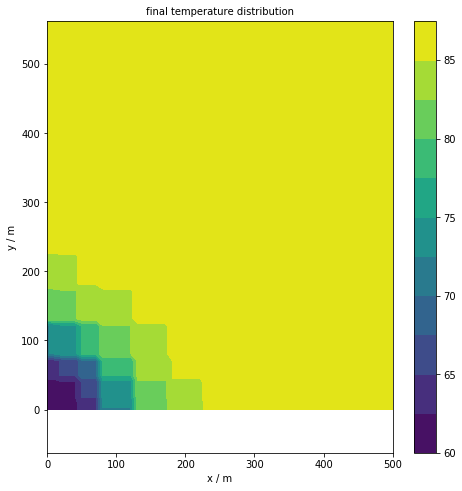

In [36]:
cont.slice_plot(save='temperature_slice.png', cbar=True, levels = 10, slice = ['z',-1000],
                divisions=[100,100], variable='T', xlims=[0,500], ylims=[0,500],
                title='final temperature distribution')

   2\. A profile plot of pressure between the injection and production wells (see Figure 7.4).

<Figure size 432x288 with 0 Axes>

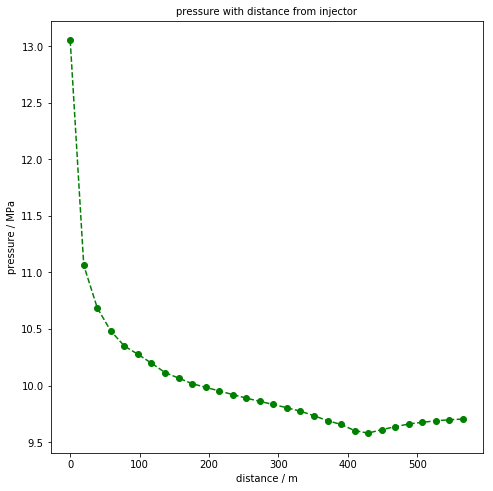

In [37]:
cont.profile_plot(save='pressure_profile.png', profile=np.array([[0,0,-1000], [400,400,-1000]]),
                  variable='P', ylabel='pressure / MPa', title='pressure with distance from injector',
                  color='g', marker='o--', method='linear')

   3\. A vertical profile plot of stress at x,y = [600,600] (see Figure 7.5).

<Figure size 432x288 with 0 Axes>

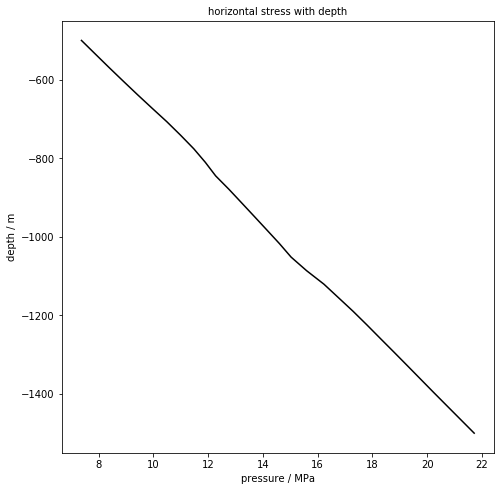

In [38]:
cont.profile_plot(save='stress_profile.png', profile=np.array([[600,600,-500], [600,600,-1500]]),
                  variable='strs_xx', xlabel='depth / m', ylabel='pressure / MPa',
                  title='horizontal stress with depth', color='k', marker='-', method='linear',
                  elevationPlot=True)

   4\. A cutway plot of temperature (see Figure 7.5).

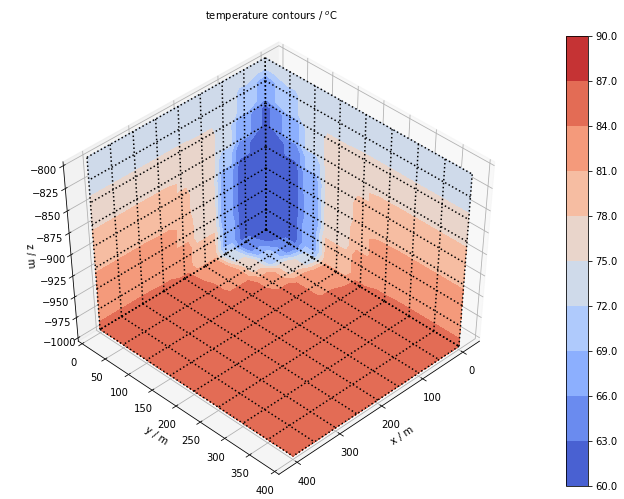

In [39]:
cont.cutaway_plot(variable='T', save='temperature_cutaway.png', xlims=[0,400], ylims=[0,400],
                  zlims=[-1000,-800], cbar=True, levels=np.linspace(60,90,11), grid_lines='k:',
                  title='temperature contours / $^o$C')

Now let’s look at some of the time-series plotting capability. First we need to read in the history output for the flow data at the production well.

In [40]:
hist=fhistory('{}/{}_flow_.his.dat'.format(work_dir, dat.files.root))

Now produce a time series plot of the production data (see Figure 7.6).

In [41]:
hist.time_plot

<bound method fhistory.time_plot of History output for variable at node.>

In [42]:
hist.time_plot(variable='flow', save='extraction_plot.png', node=hist.nodes[0], scale_t=1./365.25,
               xlabel='time / years', ylabel='flow kg s$^{-1}$')

IndexError: list index out of range